In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from minisom import MiniSom
from collections import Counter
from sklearn.metrics import silhouette_score

seed = 42
np.random.seed(seed)

In [2]:
# Read datasets
df_bio = pd.read_csv('dataset\Biomass_History.csv')
df_dist = pd.read_csv('dataset\Distance_Matrix.csv')
submission = pd.read_csv('dataset\sample_submission.csv')
df_ext = pd.read_excel('dataset\External_Data.xlsx')
df_real = pd.read_csv('dataset\Biomass_Private.csv')

In [3]:
# Expand dfbio dataset
df_bio_long = pd.melt(df_bio, id_vars=['Index','Latitude','Longitude'], var_name='Year', value_name='Bio')
df_bio_long['Year'] = df_bio_long['Year'].astype(int)
df_bio_long['Bio'] = df_bio_long['Bio'].astype(float)

years = [str(year) for year in range(2010,2017+1)]
df_bio['mean_bio'] = df_bio.apply(lambda x: np.mean(x[years]),axis=1)

In [4]:
# Aggregate external dataset
df_ext_annual = df_ext.groupby('Year').agg({
    "Avg_Temp" : "mean",
    "Min_Temp" : "min",
    "Max_Temp" : "max",
    "Rainfall" : "sum",
    "Rain_Days" : "sum",
    "Cloud" : "mean",
    "Humidity" : "mean",
    "Sun_Hours" : "sum",
    "Sun_Days" : "sum",
    "UV_Index" : "mean",
    "Pressure": "mean",
    "Avg_Gust": "mean",
    "Max_Wind": "max",
    "Avg_Wind": "mean",
}).reset_index()

In [5]:
df_train = df_bio_long.copy()
df_2018 = df_bio_long.loc[df_bio_long['Year'] == 2010].drop(columns=['Bio'])
df_2018['Year'] = 2018
df_2019 = df_bio_long.loc[df_bio_long['Year'] == 2010].drop(columns=['Bio'])
df_2019['Year'] = 2019

In [7]:
class SOMClassifier:
    def __init__(self, som_x=5, som_y=5, learning_rate=0.05):
        self.som_x = som_x
        self.som_y = som_y
        self.learning_rate = learning_rate

    def train(self, dfts_norm):
        series_data = dfts_norm.drop(columns=['Index']).values

        self.som = MiniSom(self.som_x, self.som_y, input_len=series_data.shape[1], learning_rate=self.learning_rate, random_seed=42)
        self.som.random_weights_init(series_data)

        num_epochs = 50000
        self.som.train_random(series_data, num_epochs)

        self.winners = self.som.win_map(series_data)

        cluster_indices = list(self.winners.keys())
        self.winners_indexed = {f"Cluster {i+1}": self.winners[cluster_indices[i]] for i in range(len(cluster_indices))}

        self.list_of_series = np.array([series for series_list in self.winners_indexed.values() for series in series_list])

        self.cluster_labels = []
        for cluster, series_list in self.winners_indexed.items():
            self.cluster_labels.extend([cluster] * len(series_list))

        self.cluster_labels = np.array(self.cluster_labels)

    def get_silhouette_score(self):
        silhouette_avg = silhouette_score(self.list_of_series, self.cluster_labels)
        return silhouette_avg
    
    def plot_cluster(self):
        fig, axs = plt.subplots(self.som_x,self.som_y,figsize=(min(self.som_x,self.som_y)*5,max(self.som_x,self.som_y)*5))
        for x in range(self.som_x):
            for y in range(self.som_y):
                cluster = (x,y)
                if cluster in self.winners.keys():
                    for series in self.winners[cluster]:
                        axs[cluster].plot(series,c="gray",alpha=0.5) 
                    axs[cluster].plot(dtw_barycenter_averaging(np.vstack(self.winners[cluster])),c="red")
                cluster_number = x*self.som_y+y+1
                axs[cluster].set_title(f"Cluster {cluster_number}")
            
        plt.tight_layout()
        plt.show()

    def get_df_label(self):
        columns = ['2010','2011','2012','2013','2014','2015','2016','2017','Label']
        dflabel = pd.DataFrame(columns=columns)

        rows = []
        for cluster, series_list in self.winners_indexed.items():
            for series in series_list:
                new_row = {'2010': series[0], '2011': series[1], '2012': series[2],
                        '2013': series[3], '2014': series[4], '2015': series[5],
                        '2016': series[6], '2017': series[7], 'Label': cluster}
                rows.append(new_row)

        dflabel = pd.concat([dflabel, pd.DataFrame(rows)], ignore_index=True)
        dflabel = df_ts_norm.merge(dflabel, on=list(year_cols), how='left').drop(columns=list(year_cols))
        return dflabel
    
    def plot_distribution(self):
        df = self.get_df_label()
        df['Label'].value_counts().plot(kind='bar', figsize=(15,4), title='Distribution')
    
    

In [9]:
# Create dataframe for timeseries clustering
df_ts = df_bio.drop(columns=['Latitude','Longitude','mean_bio'])
year_cols = df_ts.columns[1:]

# Create a normalized dataframe and expand
df_ts_norm = df_ts.copy()
df_ts_norm[year_cols] = df_ts_norm.apply(lambda row: (row[year_cols] - row[year_cols].min())/row[year_cols].max(), axis=1)
df_ts_long = pd.melt(df_ts_norm, id_vars=['Index'], var_name='Year', value_name='Bio')

som_x = 3
som_y = 3
som_classifier = SOMClassifier(som_x=som_x, som_y=som_y)

som_classifier.train(df_ts_norm)

som_silhouette_score = som_classifier.get_silhouette_score()
print(f'Silhouette Score: {som_silhouette_score}')

dfmean = df_bio_long.groupby(['Index','Latitude','Longitude'])['Bio'].mean().reset_index()
dflabel = som_classifier.get_df_label()

Silhouette Score: 0.20505389281858416


C:\Users\Acer\AppData\Local\Temp\ipykernel_24004\3135545466.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dflabel = pd.concat([dflabel, pd.DataFrame(rows)], ignore_index=True)


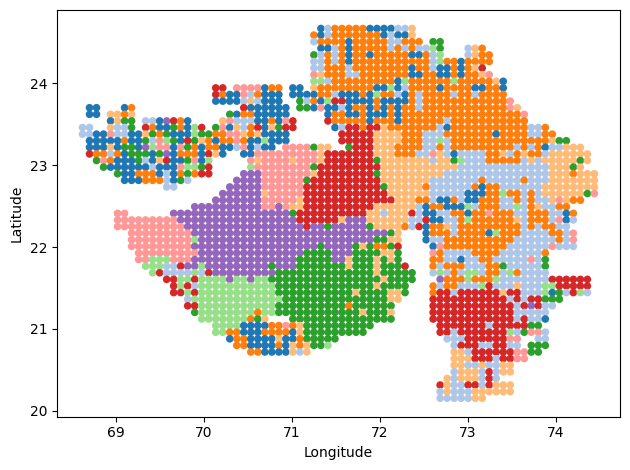

In [10]:
palette = sns.color_palette("tab20", n_colors=som_x*som_y)
sns.scatterplot(data=pd.merge(dfmean,dflabel,on='Index'),x='Longitude',y='Latitude',hue='Label', palette=palette, s=30, linewidth=0, legend=False)

plt.tight_layout()
plt.show()

In [11]:
def add_temporal(dftrain, df2018, df2019, past_count):
    for i in range(1,past_count+1):
        df_lag=df_bio_long.copy()[['Index','Year','Bio']]
        df_lag['Year'] = df_lag['Year']+i
        dftrain = dftrain.merge(df_lag, on=['Index', 'Year'], how='left',suffixes=('',f'_plus{i}'))
        df2018 = df2018.merge(df_lag, on=['Index', 'Year'], how='left',suffixes=('',f'_plus{i}'))
        df2019 = df2019.merge(df_lag, on=['Index', 'Year'], how='left',suffixes=('',f'_plus{i}'))
    
    df2018.rename(columns={'Bio': 'Bio_plus1'}, inplace=True)
    df2019.rename(columns={'Bio': 'Bio_plus1'}, inplace=True)
    return dftrain,df2018,df2019

def add_spatial(df_train, df_2018, df_2019, n_closest):
    dftrain, df2018, df2019 = df_train.copy(), df_2018.copy(), df_2019.copy()
    df_closest = pd.DataFrame(df_bio['Index'])
    df_closest['closest'] = df_bio['Index'].apply(lambda x: df_dist[str(x)].nsmallest(n_closest).index.tolist())

    for i in range(n_closest):
        dftrain['closest_'+str(i)] = dftrain.apply(lambda x:
                                                        np.nan if str(int(x['Year'])-1) not in years else
                                                        df_bio.loc[df_closest.loc[int(x['Index'])]['closest'][i],str(int(x['Year'])-1)],
                                                        axis=1)
        
        df2018['closest_'+str(i)] = df2018.apply(lambda x:
                                                        np.nan if str(int(x['Year'])-1) not in years else
                                                        df_bio.loc[df_closest.loc[int(x['Index'])]['closest'][i],str(int(x['Year'])-1)],
                                                        axis=1)
        
        df2019['closest_'+str(i)] = df2019.apply(lambda x:
                                                        np.nan if str(int(x['Year'])-1) not in years else
                                                        df_bio.loc[df_closest.loc[int(x['Index'])]['closest'][i],str(int(x['Year'])-1)],
                                                        axis=1)
    
    return dftrain, df2018, df2019

def add_label(dftrain, df2018, df2019, df_label, OHE=False): 
    dftrain = pd.merge(dftrain, df_label)
    df2018 = pd.merge(df2018, df_label)
    df2019 = pd.merge(df2019, df_label)
    if OHE :
        return pd.get_dummies(dftrain, columns=['Label']),pd.get_dummies(df2018, columns=['Label']),pd.get_dummies(df2019, columns=['Label'])
    else :
        return dftrain, df2018, df2019

def add_ext(dftrain, df2018, df2019, df_ext):
    return pd.merge(dftrain, df_ext, on='Year', how='left'),pd.merge(df2018, df_ext, on='Year', how='left'),pd.merge(df2019, df_ext, on='Year', how='left')

In [25]:
df_st_train_whole, df_st_2018_whole, df_st_2019_whole = add_spatial(df_train, df_2018, df_2019, 5)
df_st_train_whole, df_st_2018_whole, df_st_2019_whole = add_temporal(df_st_train_whole, df_st_2018_whole, df_st_2019_whole, 3)
df_stc_train_whole, df_stc_2018_whole, df_stc_2019_whole = add_label(df_st_train_whole, df_st_2018_whole, df_st_2019_whole, dflabel, OHE=True)
df_ste_train_whole, df_ste_2018_whole, df_ste_2019_whole = add_ext(df_st_train_whole, df_st_2018_whole, df_st_2019_whole, df_ext_annual)
df_stce_train_whole, df_stce_2018_whole, df_stce_2019_whole = add_ext(df_stc_train_whole, df_stc_2018_whole, df_stc_2019_whole, df_ext_annual)

In [13]:
# Import machine learning frameworks
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm

In [ ]:
def create_pipeline(model, scaler):
    pipeline = Pipeline([
        ('scaler', scaler),  # Standardize the features
        ('model', model)  # Your chosen model
    ])
    return pipeline

def eval_whole(model, splits, dftrain):
    train_err = []
    valid_err = []

    X = dftrain.copy().drop(columns=['Index','closest_0'])
    y = X.pop('Bio')

    tscv = TimeSeriesSplit(n_splits=splits, test_size=2418)

    for train_index, valid_index in tscv.split(X):
        valid_year = X.iloc[valid_index]['Year'].unique()[0]
        # print(f"Testing on year : {valid_year}")

        x_train, y_train = X.iloc[train_index], y.iloc[train_index]
        x_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]

        pipeline = create_pipeline(model, MinMaxScaler())

        pipeline.fit(x_train, y_train)

        train_pred = pipeline.predict(x_train)
        valid_pred = pipeline.predict(x_valid)

        train_score = mean_absolute_error(y_train, train_pred)
        valid_score = mean_absolute_error(y_valid, valid_pred)

        train_err.append(train_score)
        valid_err.append(valid_score)

        # print(f'Train Score {train_score:.5f}, Valid Score {valid_score:.5f}')

    print(f'Mean Train Score : {np.mean(train_err):.5f}, Mean Valid Score : {np.mean(valid_err):.5f}')

    return train_err, valid_err, pipeline

def eval_linear(model, dftrain):
    mae_list = []
    for i in dftrain['Index'].unique():
        X = dftrain[dftrain['Index']==i].copy().drop(['Index','Latitude','Longitude'],axis=1)
        y = X.pop('Bio')

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
        pipeline = create_pipeline(model, MinMaxScaler())
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        mae_list.append(mae)

    print(f"Mean Absolute Error (MAE): {np.mean(mae_list)}")
    return mae_list

In [26]:
error_dict = {}

In [28]:
df_st_train_whole.dropna(inplace=True)
df_stc_train_whole.dropna(inplace=True)
df_ste_train_whole.dropna(inplace=True)
df_stce_train_whole.dropna(inplace=True)

datasets = {
    # 'ST' : df_st_train_whole,
    # 'STC' : df_stc_train_whole,
    # 'STE' : df_ste_train_whole,
    'STCE' : df_stce_train_whole
}

models = {
    'RF' : RandomForestRegressor(random_state=seed, verbose=0),
    'LGBM' : LGBMRegressor(random_state=seed, verbosity=-1)
}

In [29]:
df_stce_train_whole['Year'].value_counts()

Year
2013    2418
2014    2418
2015    2418
2016    2418
2017    2418
Name: count, dtype: int64

In [ ]:
for model in models.keys():
    for data in datasets.keys():
        print(f'Model {model}, Data {data}')
        t_err, v_err, train_model = eval_whole(models[model], 4, datasets[data])
        error_dict[model+'_'+data] = np.mean(v_err)

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [34]:
def lr_schedule(epoch):
    if epoch < 250:
        return 0.05
    elif epoch < 450:
        return 0.01
    elif epoch < 550:
        return 0.005
    elif epoch < 600:
        return 0.001
    else :
        return 0.0005
    
def nn_valid(model, val_loader, criterion):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            pred = model(inputs)
            val_loss += criterion(pred,targets).item()
        
    avg_val_loss = val_loss/len(val_loader)
    return avg_val_loss
    
def nn_eval(df, hidden=[64,32,32]):
    x = df.copy().drop(['Index','closest_0'],axis=1)
    y = x.pop('Bio')
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x)

    x = torch.tensor(x.astype('float').values, dtype=torch.float32)
    y = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

    model = nn.Sequential(
        nn.Linear(x.size(1), hidden[0]),
        nn.ReLU(),
        nn.Linear(hidden[0], hidden[1]),
        nn.ReLU(),
        nn.Linear(hidden[1], hidden[2]),
        nn.ReLU(),
        nn.Linear(hidden[2], 1)
    )
    
    criterion = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=0.05)

    lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_schedule)

    num_epochs = 500
    train_loss = []
    test_losses = []  # Add this list to store test losses for each epoch

    for epoch in range(num_epochs):
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        
        train_loss.append(loss.item())
        lr_scheduler.step()

        average_test_loss = nn_valid(model, test_loader, criterion)
        test_losses.append(average_test_loss)  # Store the test loss for the current epoch

        # Print both train and test losses in one line
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {loss.item():.2f}, Test Loss: {average_test_loss:.2f}')
    
    history = {'train':train_loss, 'test':test_losses}
    loss = nn_valid(model, test_loader, criterion)
    return loss, history

In [35]:
loss, history = nn_eval(df_stce_train_whole)

Epoch 1/500, Train Loss: 62.88, Test Loss: 54.63
Epoch 2/500, Train Loss: 43.44, Test Loss: 41.76
Epoch 3/500, Train Loss: 37.90, Test Loss: 40.73
Epoch 4/500, Train Loss: 48.45, Test Loss: 39.15
Epoch 5/500, Train Loss: 40.50, Test Loss: 38.33
Epoch 6/500, Train Loss: 42.56, Test Loss: 37.78
Epoch 7/500, Train Loss: 44.99, Test Loss: 37.94
Epoch 8/500, Train Loss: 37.08, Test Loss: 37.51
Epoch 9/500, Train Loss: 42.84, Test Loss: 38.51
Epoch 10/500, Train Loss: 29.70, Test Loss: 37.14
Epoch 11/500, Train Loss: 39.20, Test Loss: 36.42
Epoch 12/500, Train Loss: 38.39, Test Loss: 38.61
Epoch 13/500, Train Loss: 37.92, Test Loss: 38.88
Epoch 14/500, Train Loss: 39.48, Test Loss: 36.21
Epoch 15/500, Train Loss: 34.15, Test Loss: 36.72
Epoch 16/500, Train Loss: 40.25, Test Loss: 35.63
Epoch 17/500, Train Loss: 36.80, Test Loss: 35.95
Epoch 18/500, Train Loss: 37.05, Test Loss: 35.37
Epoch 19/500, Train Loss: 33.93, Test Loss: 34.97
Epoch 20/500, Train Loss: 32.29, Test Loss: 37.19
Epoch 21/

19.143720054626463


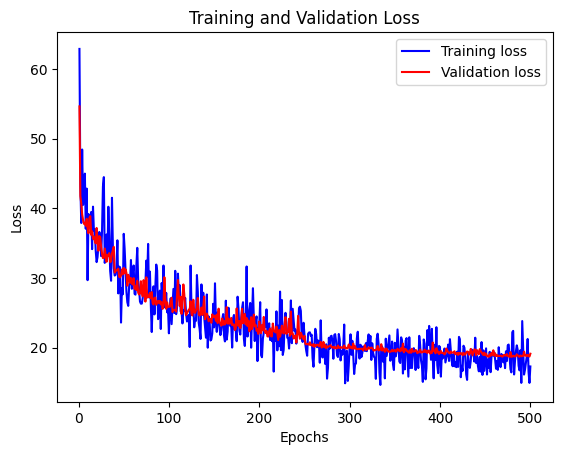

In [36]:
print(loss)
# Create a range of epochs for x-axis
epochs = range(1, len(history['train']) + 1)

# Plotting
plt.plot(epochs, history['train'], 'b', label='Training loss')
plt.plot(epochs, history['test'], 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show plot
plt.show()

In [37]:
pred_dict = {'2018': [], '2019': []} 

x_train = df_stce_train_whole.copy().drop(columns=['Index','closest_0'],axis=1)
y_train = x_train.pop('Bio')
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

x_train = torch.tensor(x_train.astype('float').values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

In [38]:
hidden = [64,64,32]

model = nn.Sequential(
        nn.Linear(x_train.size(1), hidden[0]),
        nn.ReLU(),
        nn.Linear(hidden[0], hidden[1]),
        nn.ReLU(),
        nn.Linear(hidden[1], hidden[2]),
        nn.ReLU(),
        nn.Linear(hidden[2], 1)
    )

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.05)

lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_schedule)
num_epochs = 500

In [39]:
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
    lr_scheduler.step()
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {loss.item():.2f}')

Epoch 1/500, Train Loss: 47.74
Epoch 2/500, Train Loss: 52.89
Epoch 3/500, Train Loss: 43.06
Epoch 4/500, Train Loss: 39.22
Epoch 5/500, Train Loss: 44.80
Epoch 6/500, Train Loss: 29.99
Epoch 7/500, Train Loss: 43.71
Epoch 8/500, Train Loss: 42.36
Epoch 9/500, Train Loss: 27.11
Epoch 10/500, Train Loss: 44.36
Epoch 11/500, Train Loss: 30.47
Epoch 12/500, Train Loss: 30.47
Epoch 13/500, Train Loss: 36.55
Epoch 14/500, Train Loss: 30.22
Epoch 15/500, Train Loss: 33.27
Epoch 16/500, Train Loss: 37.63
Epoch 17/500, Train Loss: 27.11
Epoch 18/500, Train Loss: 51.03
Epoch 19/500, Train Loss: 41.69
Epoch 20/500, Train Loss: 20.93
Epoch 21/500, Train Loss: 44.46
Epoch 22/500, Train Loss: 27.30
Epoch 23/500, Train Loss: 29.25
Epoch 24/500, Train Loss: 34.18
Epoch 25/500, Train Loss: 36.58
Epoch 26/500, Train Loss: 23.67
Epoch 27/500, Train Loss: 29.59
Epoch 28/500, Train Loss: 25.09
Epoch 29/500, Train Loss: 29.72
Epoch 30/500, Train Loss: 30.26
Epoch 31/500, Train Loss: 32.08
Epoch 32/500, Tra

In [40]:
cp_path = './saved_models/nn_500_12.pth'

checkpoint = {
    'epoch': num_epochs,
    'hidden_layers': [64, 32, 32],
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'lr_init': 0.05
}

torch.save(checkpoint, cp_path)

In [41]:
x_2018 = df_stce_2018_whole.copy().drop(['Index','closest_0'],axis=1)
x_2018_scaled = scaler.transform(x_2018)
x_2018 = torch.tensor(x_2018.astype('float').values, dtype=torch.float32)

In [63]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    pred_2018 = model(x_2018)

In [68]:
pred_2018 = np.array([0 if x < 0 else x for x in pred_2018.numpy()[:,0]])

<Axes: ylabel='Count'>

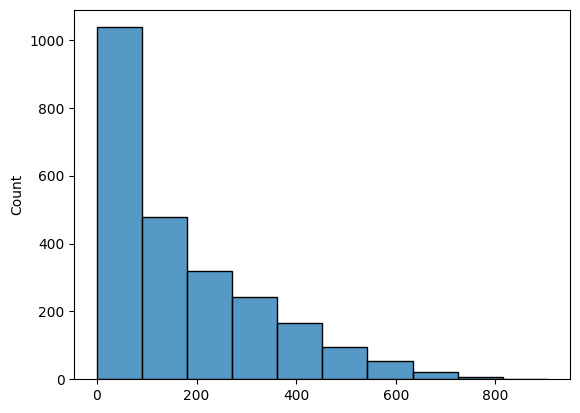

In [69]:
sns.histplot(pred_2018,bins=10)

In [70]:
df_real['2018']

0        7.119092
1       45.937351
2       75.666054
3       94.867676
4       18.417318
          ...    
2413     4.404175
2414     0.097374
2415     0.031385
2416     1.052878
2417     0.183205
Name: 2018, Length: 2418, dtype: float64

In [72]:
pred_2018

array([ 2.02499032, 24.9272995 , 46.54669571, ...,  0.        ,
        3.30406404,  3.04617524])

In [74]:
mean_absolute_error(df_real['2018'].values, pred_2018)

65.4511040593496